In [1]:
import cnn_functions
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchvision import  transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Multiclass output

In [2]:
labels_map = {
    0: "REAL Truck",
    1: "REAL Car",
    2: "REAL Bird",
    3: "REAL Cat",
    4: "REAL Deer",
    5: "REAL Dog",
    6: "REAL Frog",
    7: "REAL Horse",
    8: "REAL Ship",
    9: "REAL Plane",
    10: "FAKE Truck",
    11: "FAKE Car",
    12: "FAKE Bird",
    13: "FAKE Cat",
    14: "FAKE Deer",
    15: "FAKE Dog",
    16: "FAKE Frog",
    17: "FAKE Horse",
    18: "FAKE Ship",
    19: "FAKE Plane"
}

class MulticlassDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.img_dir = img_dir
        self.img_labels = []
        self.img_paths = []
        for g, generated in enumerate(["REAL", "FAKE"]):
            image_files = os.listdir(img_dir + "/" + generated)
            for label, image_name in enumerate(image_files):
                self.img_labels.append(label%10 + g*10)
                self.img_paths.append(os.path.join(generated, image_name))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Compose the transform to perform on the data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# 100k samples for training
train_ds = MulticlassDataset(img_dir='./archive/train', transform=transform)

# 10k samples for validation and 10k samples for testing
test_val_ds= MulticlassDataset(img_dir='./archive/test', transform=transform)
# Perform a stratified split
idx_train, idx_val = train_test_split(
    range(len(test_val_ds)),
    test_size=0.5,  # 50-50 split
    stratify=test_val_ds.img_labels,
    random_state=0
)
# Define the subsets
test_ds = Subset(test_val_ds, idx_train)
validation_ds = Subset(test_val_ds, idx_val)

# Feature extraction

In [4]:
def multiclass_feature_extraction(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    model.fc = torch.nn.Linear(512, 20) 
  
    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    return model, optimizer



 - multiclass_feature_extraction_lr0001_batch64_epochs30

Epoch 1; Train err = 63.97; Val err = 64.24; Loss: 2.4554
Epoch 2; Train err = 59.42; Val err = 60.38; Loss: 2.0569
Epoch 3; Train err = 57.66; Val err = 58.72; Loss: 1.9487
Epoch 4; Train err = 56.71; Val err = 57.65; Loss: 1.9010
Epoch 5; Train err = 56.19; Val err = 57.53; Loss: 1.8714
Epoch 10; Train err = 54.23; Val err = 55.73; Loss: 1.8012
Epoch 15; Train err = 53.40; Val err = 55.30; Loss: 1.7773
Epoch 20; Train err = 53.05; Val err = 54.27; Loss: 1.7661
Epoch 25; Train err = 53.47; Val err = 55.01; Loss: 1.7552
Epoch 30; Train err = 52.93; Val err = 54.50; Loss: 1.7535


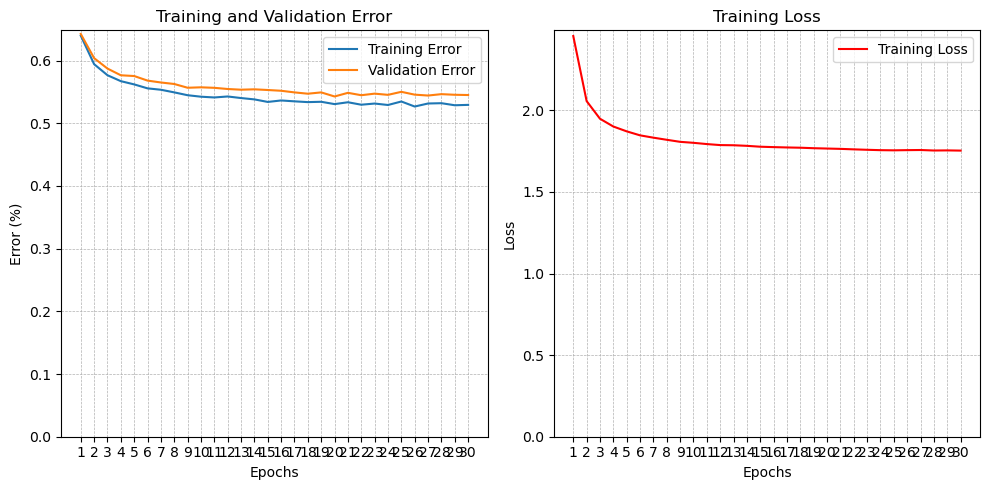



 - multiclass_feature_extraction_lr0001_batch256_epochs30

Epoch 1; Train err = 71.19; Val err = 72.25; Loss: 2.7303
Epoch 2; Train err = 64.13; Val err = 65.08; Loss: 2.2749
Epoch 3; Train err = 61.34; Val err = 62.65; Loss: 2.1043
Epoch 4; Train err = 59.74; Val err = 60.87; Loss: 2.0174
Epoch 5; Train err = 58.48; Val err = 59.60; Loss: 1.9593
Epoch 10; Train err = 55.88; Val err = 57.22; Loss: 1.8351
Epoch 15; Train err = 54.71; Val err = 56.12; Loss: 1.7875
Epoch 20; Train err = 54.01; Val err = 55.84; Loss: 1.7633
Epoch 25; Train err = 53.51; Val err = 55.29; Loss: 1.7421
Epoch 30; Train err = 53.18; Val err = 54.93; Loss: 1.7330


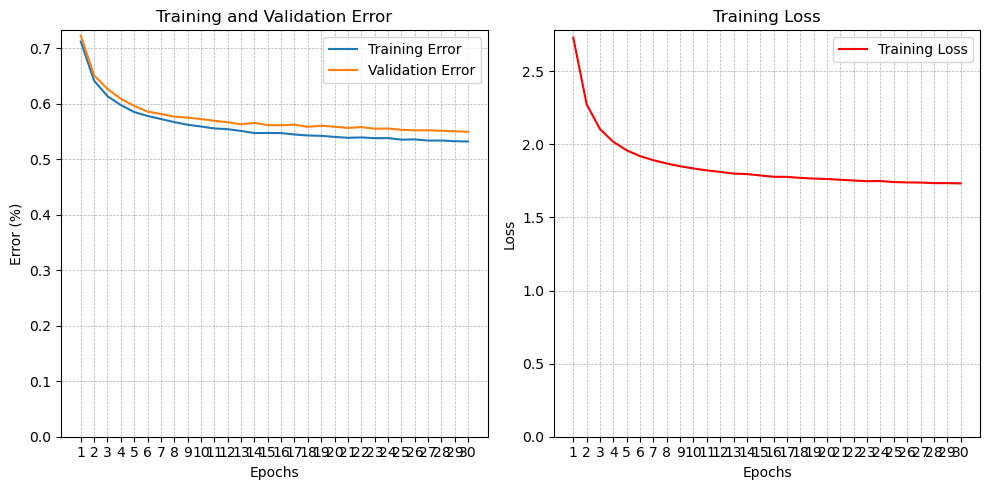



 - multiclass_feature_extraction_lr-05_batch64_epochs30

Epoch 1; Train err = 89.94; Val err = 89.59; Loss: 3.1402
Epoch 2; Train err = 82.50; Val err = 83.08; Loss: 2.8459
Epoch 3; Train err = 76.91; Val err = 77.20; Loss: 2.6517
Epoch 4; Train err = 73.54; Val err = 73.81; Loss: 2.5133
Epoch 5; Train err = 70.47; Val err = 70.70; Loss: 2.4126
Epoch 10; Train err = 63.98; Val err = 63.97; Loss: 2.1592
Epoch 15; Train err = 61.08; Val err = 61.39; Loss: 2.0458
Epoch 20; Train err = 59.02; Val err = 59.83; Loss: 1.9849
Epoch 25; Train err = 58.36; Val err = 59.02; Loss: 1.9410
Epoch 30; Train err = 57.76; Val err = 58.20; Loss: 1.9120


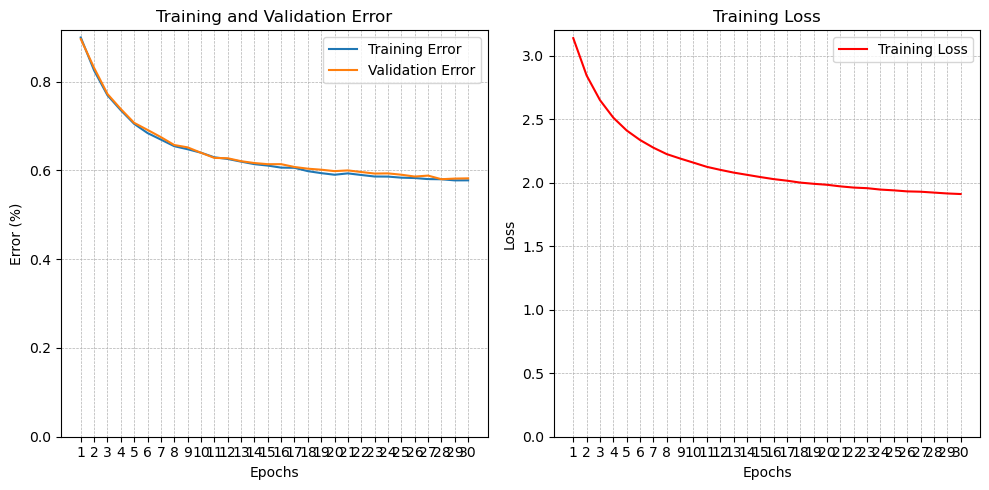



 - multiclass_feature_extraction_lr-05_batch256_epochs30

Epoch 1; Train err = 93.34; Val err = 93.24; Loss: 3.2056
Epoch 2; Train err = 90.30; Val err = 90.43; Loss: 3.0427
Epoch 3; Train err = 86.79; Val err = 87.06; Loss: 2.9216
Epoch 4; Train err = 83.38; Val err = 83.40; Loss: 2.8200
Epoch 5; Train err = 80.60; Val err = 80.40; Loss: 2.7288
Epoch 10; Train err = 71.27; Val err = 71.73; Loss: 2.4281
Epoch 15; Train err = 66.69; Val err = 67.41; Loss: 2.2649
Epoch 20; Train err = 64.01; Val err = 64.63; Loss: 2.1620
Epoch 25; Train err = 62.05; Val err = 62.54; Loss: 2.0930
Epoch 30; Train err = 61.02; Val err = 61.54; Loss: 2.0421


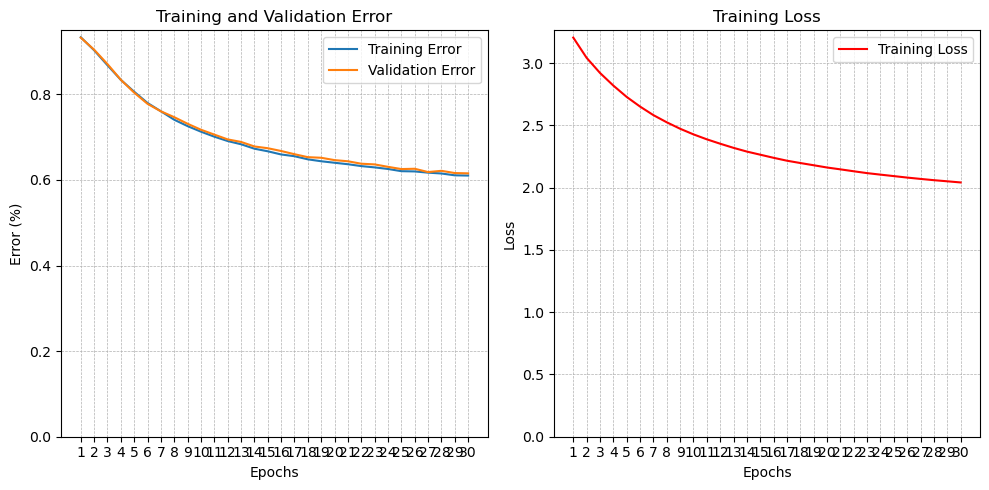

In [6]:
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [64, 256]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_feature_extraction(lr)

        print(f"\n\n - multiclass_feature_extraction_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_feature_extraction_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Feature extraction (1 hidden layer)

In [4]:
def multiclass_extraction_hidden(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),  # Additional layer
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 20)  # Output layer
    )

    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    return model, optimizer



 - multiclass_extraction_hidden_lr0001_batch4_epochs30

Epoch 1; Train err = 74.29; Val err = 73.93; Loss: 2.5641
Epoch 2; Train err = 69.48; Val err = 69.48; Loss: 2.4043
Epoch 3; Train err = 71.11; Val err = 71.16; Loss: 2.3715
Epoch 4; Train err = 68.70; Val err = 68.59; Loss: 2.3533
Epoch 5; Train err = 68.45; Val err = 68.68; Loss: 2.3512
Epoch 10; Train err = 68.02; Val err = 67.71; Loss: 2.3249
Epoch 15; Train err = 67.36; Val err = 67.51; Loss: 2.3217
Epoch 20; Train err = 69.90; Val err = 69.82; Loss: 2.3148
Epoch 25; Train err = 66.41; Val err = 66.11; Loss: 2.3110
Epoch 30; Train err = 67.62; Val err = 68.12; Loss: 2.3147


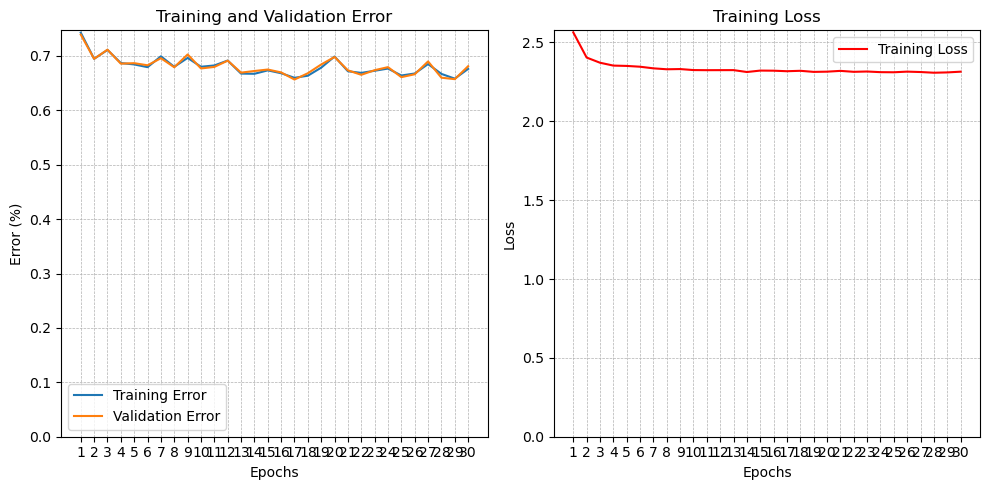



 - multiclass_extraction_hidden_lr0001_batch256_epochs30

Epoch 1; Train err = 67.02; Val err = 67.52; Loss: 2.7411
Epoch 2; Train err = 61.73; Val err = 62.19; Loss: 2.3281
Epoch 3; Train err = 59.46; Val err = 60.17; Loss: 2.1646
Epoch 4; Train err = 57.98; Val err = 58.57; Loss: 2.0844
Epoch 5; Train err = 57.26; Val err = 58.26; Loss: 2.0322
Epoch 10; Train err = 54.65; Val err = 55.30; Loss: 1.9054
Epoch 15; Train err = 53.45; Val err = 54.64; Loss: 1.8528
Epoch 20; Train err = 52.29; Val err = 53.51; Loss: 1.8191
Epoch 25; Train err = 51.66; Val err = 53.01; Loss: 1.7937
Epoch 30; Train err = 50.92; Val err = 52.65; Loss: 1.7731


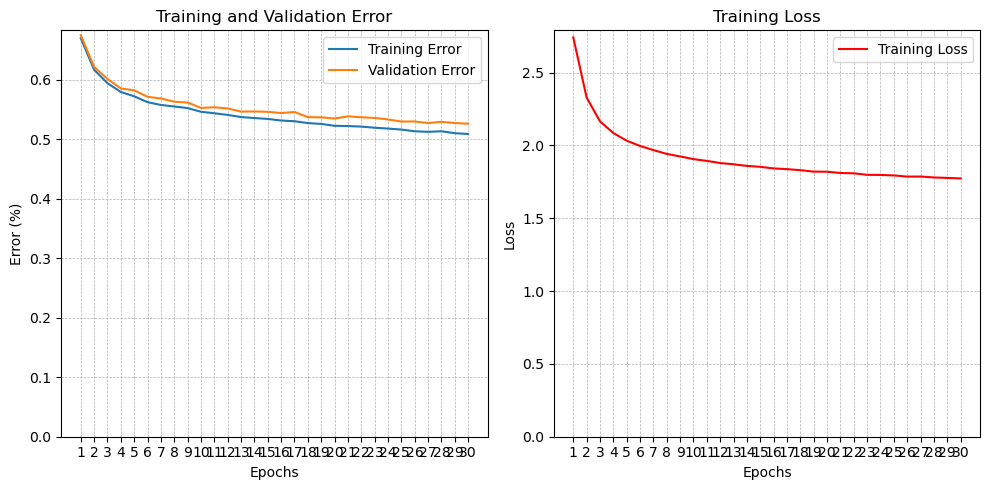



 - multiclass_extraction_hidden_lr-05_batch4_epochs30

Epoch 1; Train err = 82.03; Val err = 82.60; Loss: 2.8912
Epoch 2; Train err = 75.79; Val err = 75.98; Loss: 2.6644
Epoch 3; Train err = 73.08; Val err = 73.50; Loss: 2.5572
Epoch 4; Train err = 73.50; Val err = 73.17; Loss: 2.4932
Epoch 5; Train err = 71.05; Val err = 71.71; Loss: 2.4555
Epoch 10; Train err = 71.18; Val err = 71.35; Loss: 2.3667
Epoch 15; Train err = 69.21; Val err = 69.06; Loss: 2.3349
Epoch 20; Train err = 67.97; Val err = 68.05; Loss: 2.3187
Epoch 25; Train err = 69.21; Val err = 69.06; Loss: 2.3122
Epoch 30; Train err = 67.00; Val err = 67.74; Loss: 2.2981


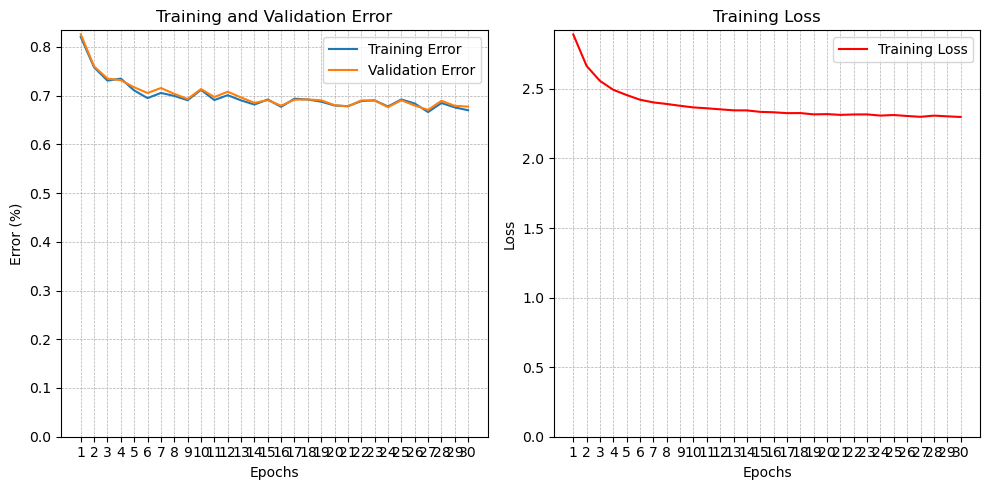



 - multiclass_extraction_hidden_lr-05_batch256_epochs30

Epoch 1; Train err = 91.85; Val err = 91.54; Loss: 3.0482
Epoch 2; Train err = 86.89; Val err = 86.83; Loss: 2.9648
Epoch 3; Train err = 82.65; Val err = 82.31; Loss: 2.9112
Epoch 4; Train err = 78.89; Val err = 78.63; Loss: 2.8545
Epoch 5; Train err = 75.72; Val err = 75.84; Loss: 2.7935
Epoch 10; Train err = 67.29; Val err = 67.24; Loss: 2.5187
Epoch 15; Train err = 63.86; Val err = 64.23; Loss: 2.3560
Epoch 20; Train err = 61.77; Val err = 62.43; Loss: 2.2575
Epoch 25; Train err = 60.37; Val err = 60.89; Loss: 2.1861
Epoch 30; Train err = 59.43; Val err = 60.27; Loss: 2.1332


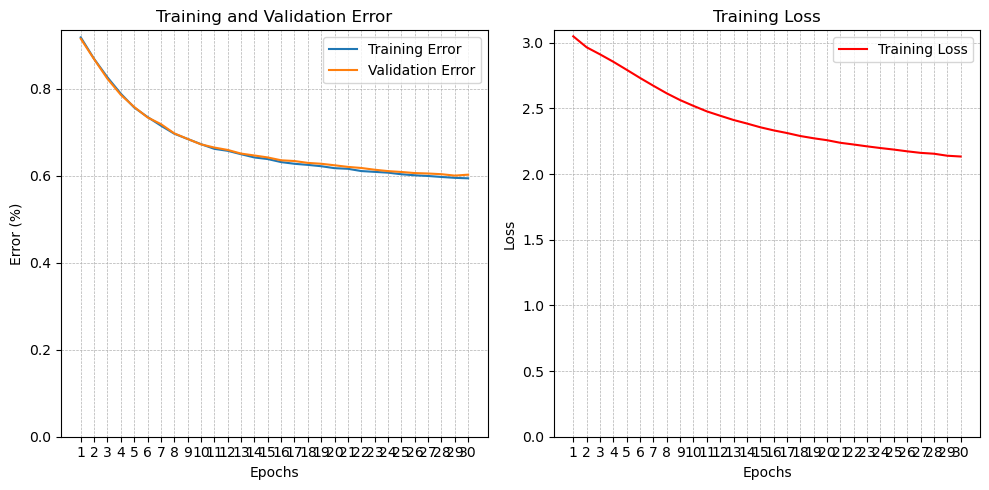

In [7]:
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [4, 256]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_extraction_hidden(lr)/

        print(f"\n\n - multiclass_extraction_hidden_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_extraction_hidden_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Feature extraction (2 hidden layers)

In [8]:
def multiclass_extraction_double_hidden(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),  # Hidden layer 1
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 64),  # Hidden layer 2
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(64, 20)  # Output layer
    )

    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    return model, optimizer



 - multiclass_extraction_double_hidden0001_batch4_epochs30

Epoch 1; Train err = 74.52; Val err = 75.00; Loss: 2.7100
Epoch 2; Train err = 73.24; Val err = 73.07; Loss: 2.5275
Epoch 3; Train err = 71.96; Val err = 72.13; Loss: 2.4867
Epoch 4; Train err = 71.28; Val err = 71.17; Loss: 2.4604
Epoch 5; Train err = 69.74; Val err = 69.21; Loss: 2.4448
Epoch 10; Train err = 69.67; Val err = 69.88; Loss: 2.4178
Epoch 15; Train err = 69.01; Val err = 68.98; Loss: 2.4034
Epoch 20; Train err = 68.33; Val err = 68.30; Loss: 2.4045
Epoch 25; Train err = 68.18; Val err = 68.03; Loss: 2.3897
Epoch 30; Train err = 66.85; Val err = 67.32; Loss: 2.3874


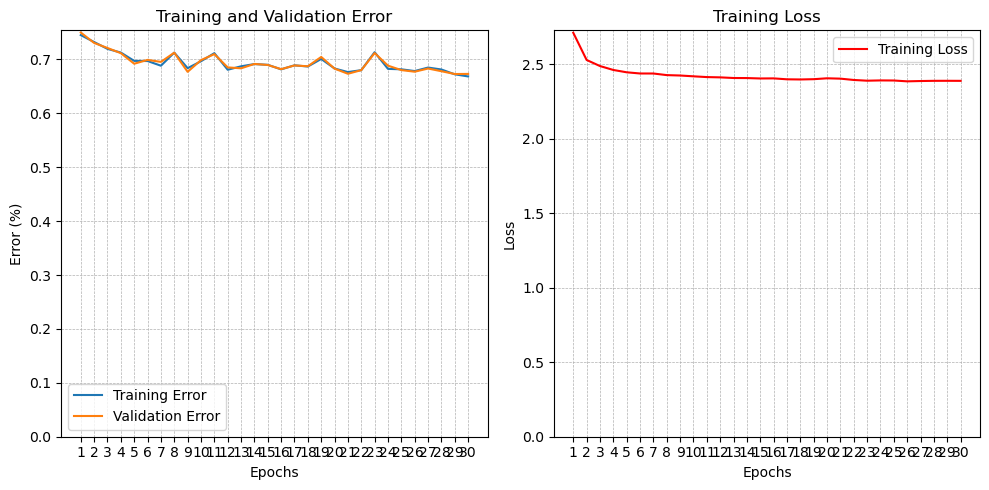



 - multiclass_extraction_double_hidden0001_batch256_epochs30

Epoch 1; Train err = 76.41; Val err = 76.34; Loss: 2.9301
Epoch 2; Train err = 68.03; Val err = 68.05; Loss: 2.6355
Epoch 3; Train err = 64.15; Val err = 64.59; Loss: 2.4327
Epoch 4; Train err = 62.61; Val err = 62.88; Loss: 2.3216
Epoch 5; Train err = 61.40; Val err = 61.93; Loss: 2.2513
Epoch 10; Train err = 58.02; Val err = 58.83; Loss: 2.0957
Epoch 15; Train err = 56.40; Val err = 57.44; Loss: 2.0306
Epoch 20; Train err = 55.14; Val err = 56.17; Loss: 1.9886
Epoch 25; Train err = 54.33; Val err = 55.79; Loss: 1.9620
Epoch 30; Train err = 53.61; Val err = 55.07; Loss: 1.9409


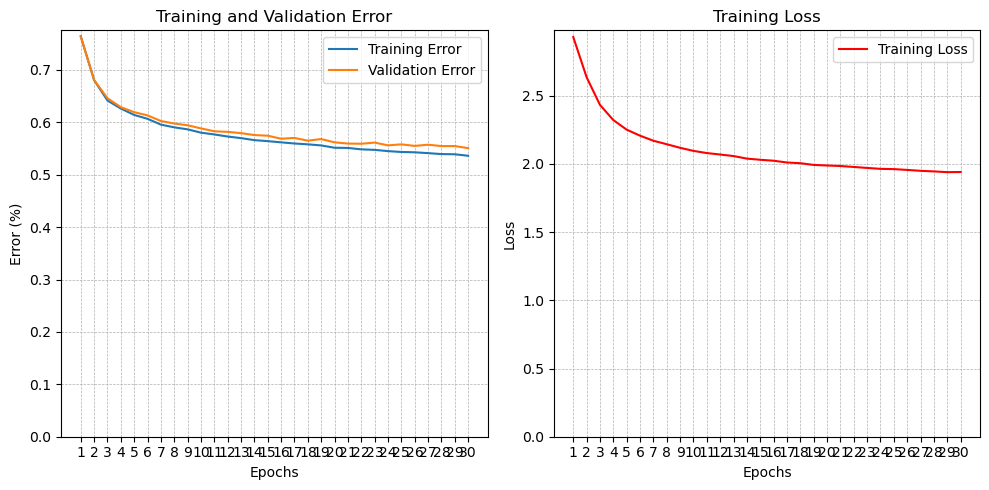



 - multiclass_extraction_double_hidden-05_batch4_epochs30

Epoch 1; Train err = 86.20; Val err = 85.91; Loss: 2.9750
Epoch 2; Train err = 81.27; Val err = 81.33; Loss: 2.8585
Epoch 3; Train err = 78.93; Val err = 79.61; Loss: 2.7489
Epoch 4; Train err = 77.51; Val err = 77.61; Loss: 2.6784
Epoch 5; Train err = 76.56; Val err = 77.07; Loss: 2.6301
Epoch 10; Train err = 71.63; Val err = 72.11; Loss: 2.5138
Epoch 15; Train err = 70.87; Val err = 71.28; Loss: 2.4640
Epoch 20; Train err = 70.43; Val err = 70.79; Loss: 2.4424
Epoch 25; Train err = 70.33; Val err = 70.28; Loss: 2.4272
Epoch 30; Train err = 69.95; Val err = 70.00; Loss: 2.4154


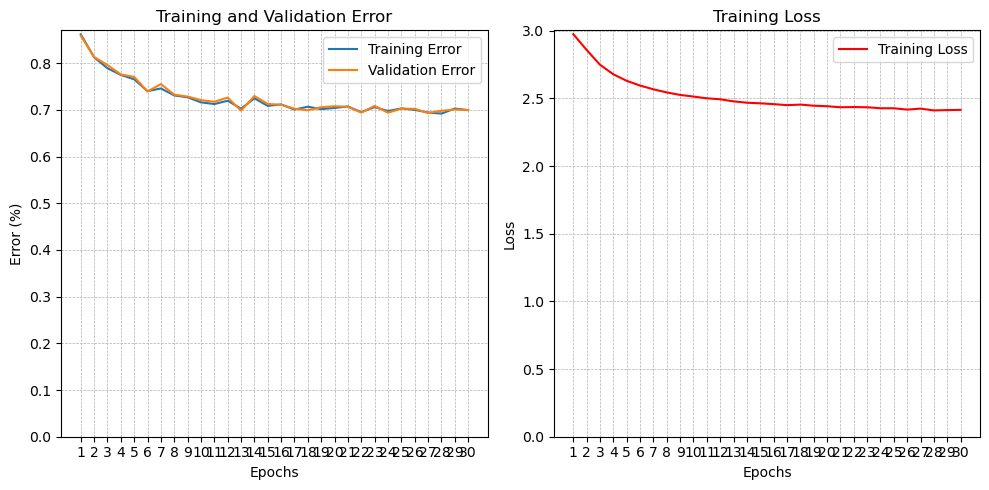



 - multiclass_extraction_double_hidden-05_batch256_epochs30

Epoch 1; Train err = 93.26; Val err = 94.03; Loss: 3.0130
Epoch 2; Train err = 91.05; Val err = 91.49; Loss: 2.9933
Epoch 3; Train err = 88.47; Val err = 88.72; Loss: 2.9814
Epoch 4; Train err = 85.44; Val err = 86.04; Loss: 2.9662
Epoch 5; Train err = 83.27; Val err = 83.50; Loss: 2.9476
Epoch 10; Train err = 74.42; Val err = 75.29; Loss: 2.8109
Epoch 15; Train err = 70.67; Val err = 71.29; Loss: 2.6637
Epoch 20; Train err = 67.80; Val err = 68.74; Loss: 2.5508
Epoch 25; Train err = 65.78; Val err = 66.66; Loss: 2.4700
Epoch 30; Train err = 64.37; Val err = 64.85; Loss: 2.4079


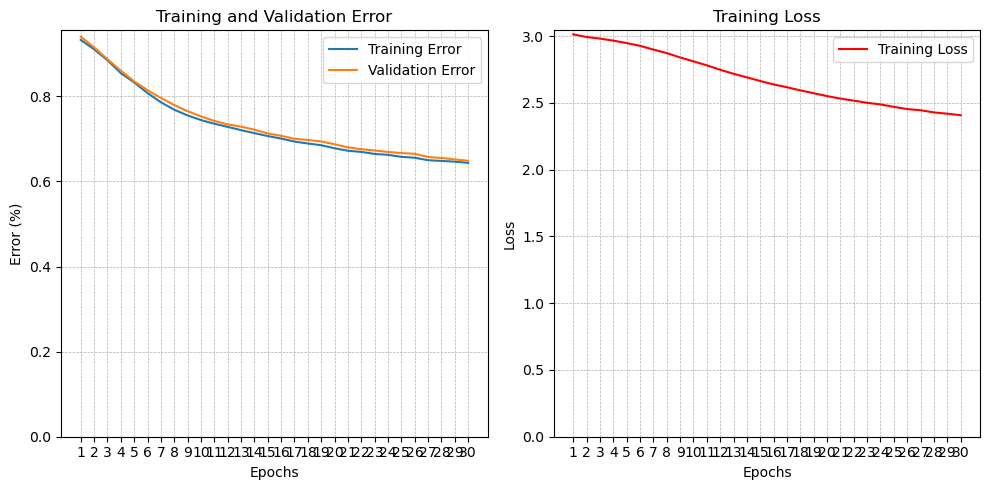

In [9]:
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [4, 256]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_extraction_double_hidden(lr)

        print(f"\n\n - multiclass_extraction_double_hidden{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_extraction_double_hidden_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Fine tuning

In [10]:
def multiclass_finetuning(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Replace the last fully connected layer
    model.fc = torch.nn.Linear(512, 20)

    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    return model, optimizer



 - multiclass_finetuning_lr0001_batch4_epochs30

Epoch 1; Train err = 32.99; Val err = 33.17; Loss: 1.6653
Epoch 2; Train err = 25.21; Val err = 27.11; Loss: 1.1437
Epoch 3; Train err = 26.92; Val err = 28.97; Loss: 0.9368
Epoch 4; Train err = 21.09; Val err = 23.80; Loss: 0.8169
Epoch 5; Train err = 22.85; Val err = 26.79; Loss: 0.7266
Epoch 10; Train err = 11.79; Val err = 19.49; Loss: 0.4678
Epoch 15; Train err = 8.70; Val err = 19.32; Loss: 0.3172
Epoch 20; Train err = 7.87; Val err = 19.54; Loss: 0.2274
Epoch 25; Train err = 5.53; Val err = 18.87; Loss: 0.1757
Epoch 30; Train err = 7.92; Val err = 21.64; Loss: 0.1420


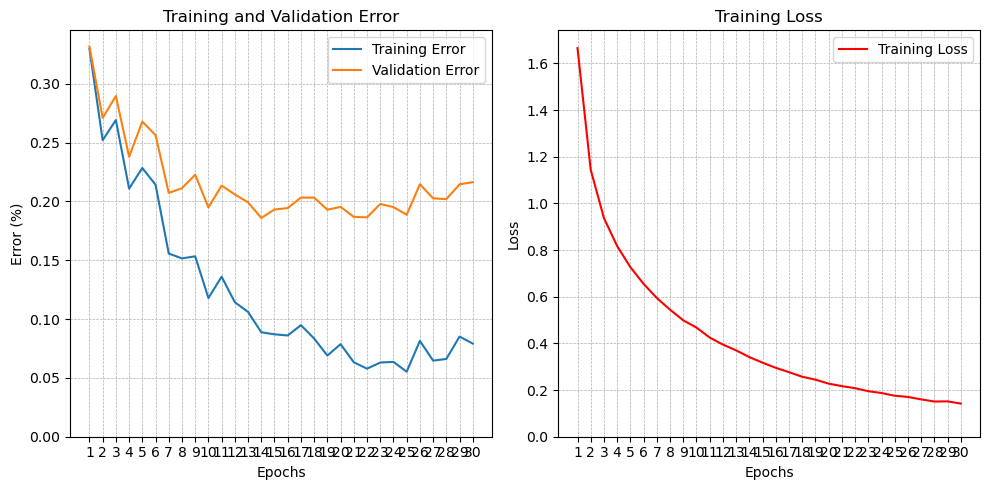



 - multiclass_finetuning_lr0001_batch256_epochs30

Epoch 1; Train err = 16.21; Val err = 20.43; Loss: 1.0242
Epoch 2; Train err = 9.47; Val err = 16.75; Loss: 0.4836
Epoch 3; Train err = 5.73; Val err = 16.07; Loss: 0.3254
Epoch 4; Train err = 3.36; Val err = 15.40; Loss: 0.2155
Epoch 5; Train err = 1.99; Val err = 16.11; Loss: 0.1387
Epoch 10; Train err = 0.76; Val err = 15.56; Loss: 0.0469
Epoch 15; Train err = 0.60; Val err = 14.67; Loss: 0.0314
Epoch 20; Train err = 0.59; Val err = 15.18; Loss: 0.0267
Epoch 25; Train err = 0.34; Val err = 14.78; Loss: 0.0222
Epoch 30; Train err = 0.18; Val err = 13.99; Loss: 0.0187


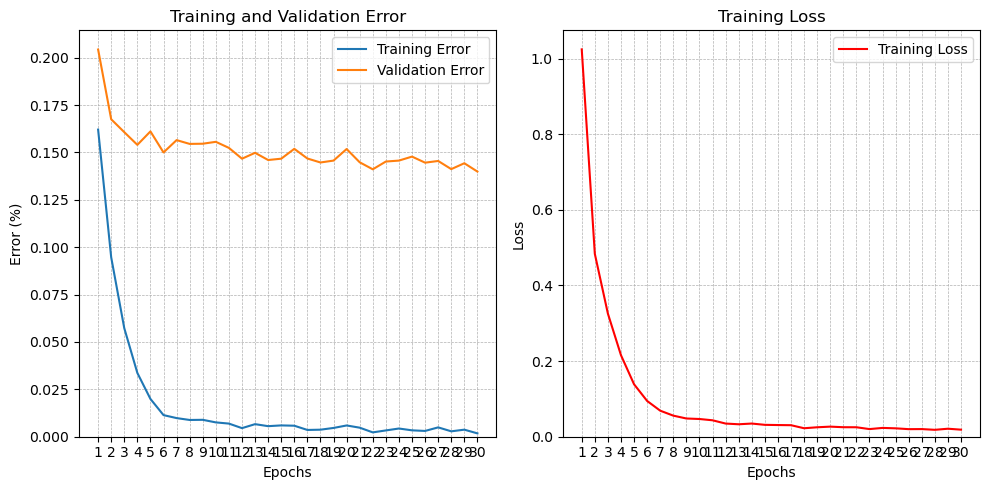



 - multiclass_finetuning_lr-05_batch4_epochs30

Epoch 1; Train err = 46.12; Val err = 46.03; Loss: 2.0494
Epoch 2; Train err = 36.07; Val err = 36.73; Loss: 1.5992
Epoch 3; Train err = 33.33; Val err = 34.11; Loss: 1.4283
Epoch 4; Train err = 29.34; Val err = 30.53; Loss: 1.3077
Epoch 5; Train err = 26.29; Val err = 26.80; Loss: 1.2171
Epoch 10; Train err = 20.61; Val err = 22.17; Loss: 0.9188
Epoch 15; Train err = 17.08; Val err = 20.51; Loss: 0.7477
Epoch 20; Train err = 15.30; Val err = 19.85; Loss: 0.6278
Epoch 25; Train err = 11.83; Val err = 17.87; Loss: 0.5358
Epoch 30; Train err = 10.88; Val err = 17.29; Loss: 0.4631


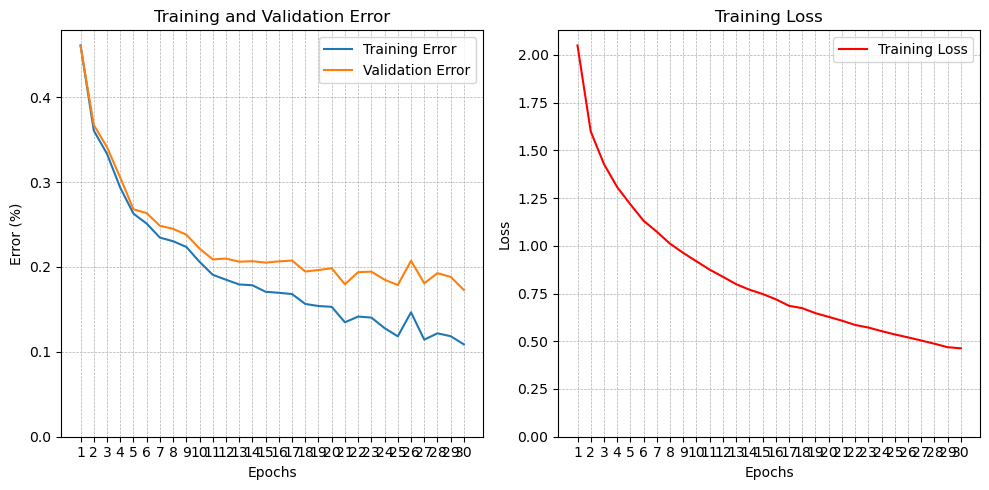



 - multiclass_finetuning_lr-05_batch256_epochs30

Epoch 1; Train err = 48.09; Val err = 49.34; Loss: 2.3596
Epoch 2; Train err = 33.33; Val err = 35.18; Loss: 1.3233
Epoch 3; Train err = 27.09; Val err = 29.41; Loss: 0.9759
Epoch 4; Train err = 23.05; Val err = 26.42; Loss: 0.8095
Epoch 5; Train err = 20.22; Val err = 24.55; Loss: 0.7052
Epoch 10; Train err = 11.09; Val err = 20.37; Loss: 0.4292
Epoch 15; Train err = 5.17; Val err = 18.71; Loss: 0.2631
Epoch 20; Train err = 1.63; Val err = 18.18; Loss: 0.1429
Epoch 25; Train err = 0.30; Val err = 18.22; Loss: 0.0692
Epoch 30; Train err = 0.05; Val err = 18.03; Loss: 0.0332


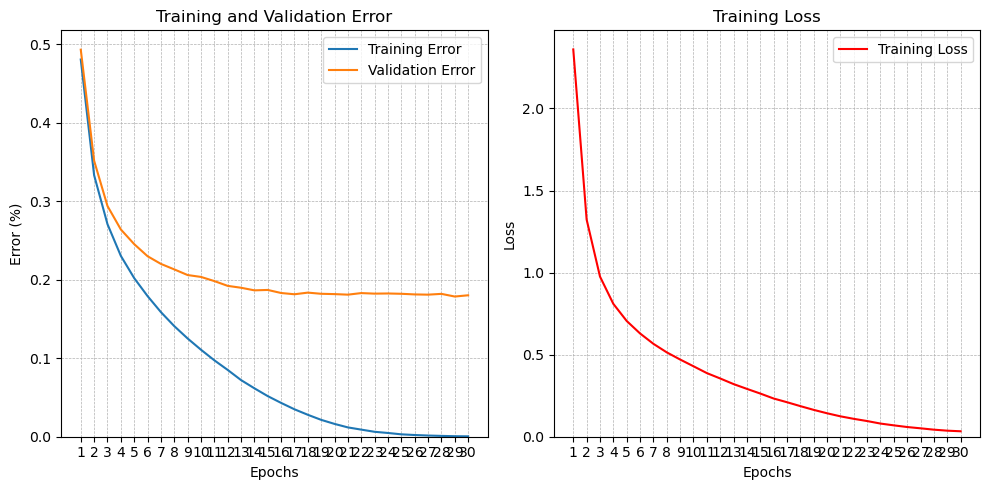

In [11]:
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [4, 256]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_finetuning(lr)

        print(f"\n\n - multiclass_finetuning_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_finetuning_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, class_names, figsize):
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Test accuracy: 86.01%


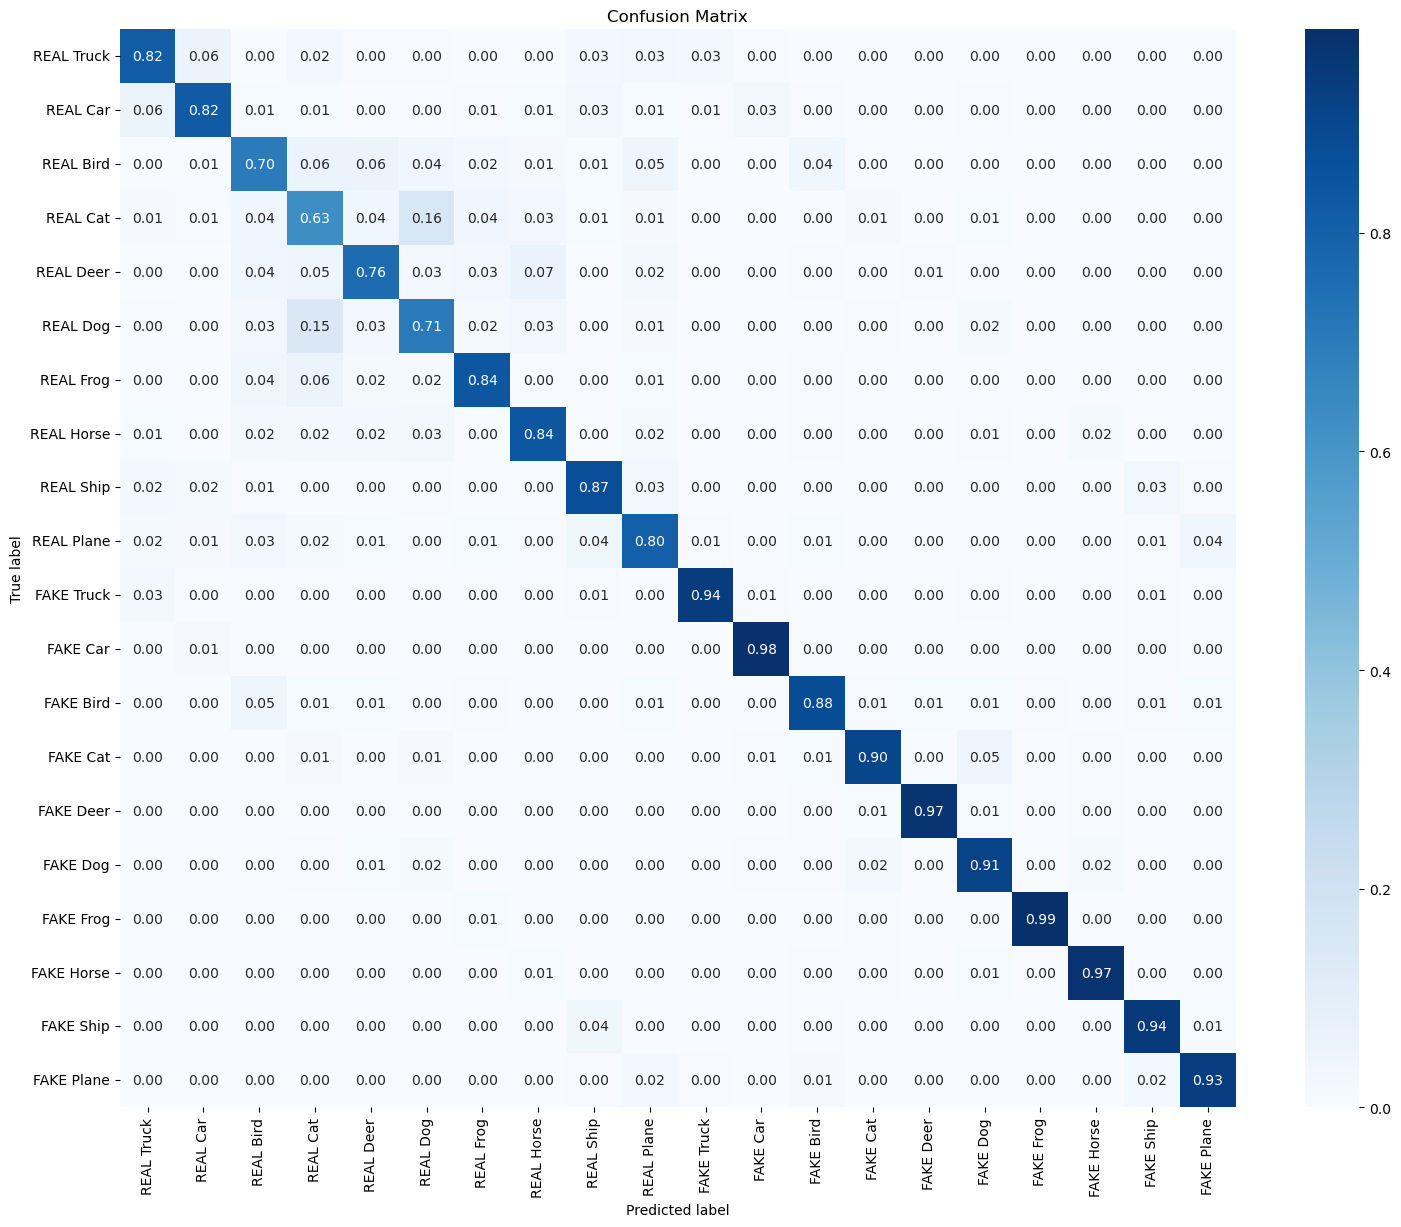

In [18]:
test_loader = DataLoader(validation_ds, batch_size=1000, shuffle=True)

model, _ = multiclass_finetuning(1)
model.load_state_dict(torch.load('./weights/multiclass_finetuning_lr0001_batch256_epochs30.pth'))
model.eval()  
device = next(model.parameters()).device

total_correct = 0
total_images = 0
confusion_matrix = torch.zeros(20, 20)  

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[label.long(), prediction.long()] += 1

accuracy = total_correct / total_images
test_error = 1 - accuracy

print(f'Test accuracy: {accuracy*100:.2f}%')

confusion_matrix_np = confusion_matrix.numpy()

def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(18, 14))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = []
_ = [class_names.append(labels_map[c]) for c in labels_map] 
plot_confusion_matrix(confusion_matrix_np, class_names, (18, 14))

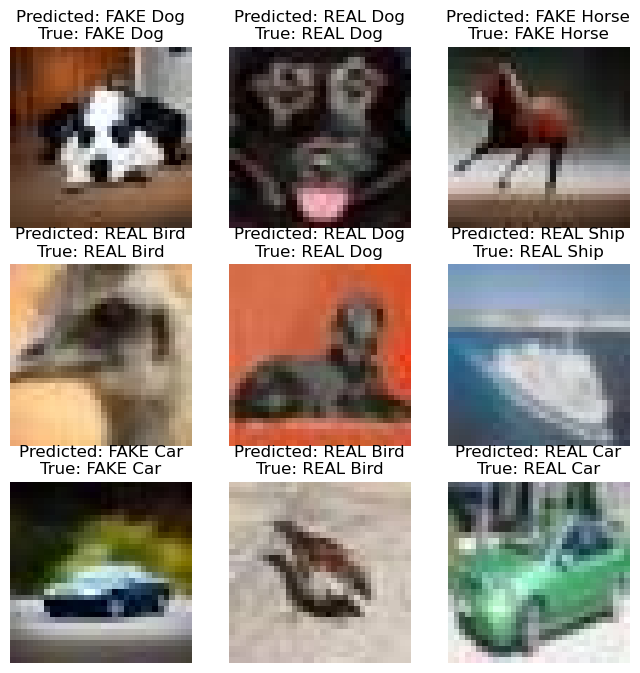

In [13]:
import torch
import matplotlib.pyplot as plt

model.eval()  

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, true_label = train_ds[sample_idx]
    img_tensor = img.unsqueeze(0)  # Add batch dimension

    # Move to the same device as the model
    img_tensor = img_tensor.to(next(model.parameters()).device)

    with torch.no_grad():  
        logits = model(img_tensor)
        predicted_label = torch.argmax(logits, dim=1).item()

    img = img.cpu().numpy().transpose((1, 2, 0))  # Adjust for matplotlib (H, W, C)

    figure.add_subplot(rows, cols, i)
    plt.title(f'Predicted: {labels_map[predicted_label]}\nTrue: {labels_map[true_label]}')
    plt.axis("off")
    plt.imshow(img)
plt.show()


Test accuracy: 96.97%


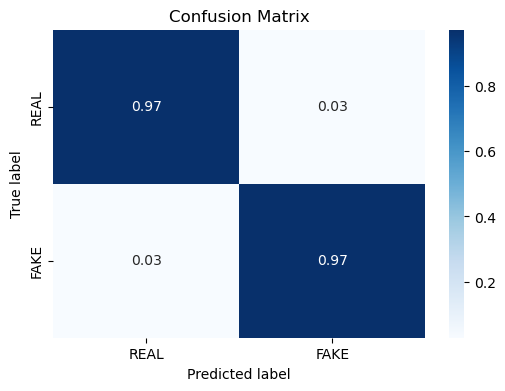

In [14]:
test_loader = DataLoader(validation_ds, batch_size=1000, shuffle=True)

model, _ = multiclass_finetuning(1)
model.load_state_dict(torch.load('./weights/multiclass_finetuning_lr0001_batch256_epochs30.pth'))
model.eval()  
device = next(model.parameters()).device

total_correct = 0
total_images = 0
confusion_matrix = torch.zeros(2, 2)  

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels // 10
        labels = labels.to(device)

        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted // 10
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[label.long(), prediction.long()] += 1

accuracy = total_correct / total_images
test_error = 1 - accuracy

print(f'Test accuracy: {accuracy*100:.2f}%')

confusion_matrix_np = confusion_matrix.numpy()

def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = ['REAL', 'FAKE']
plot_confusion_matrix(confusion_matrix_np, class_names, (6, 4))

Test accuracy: 88.07%


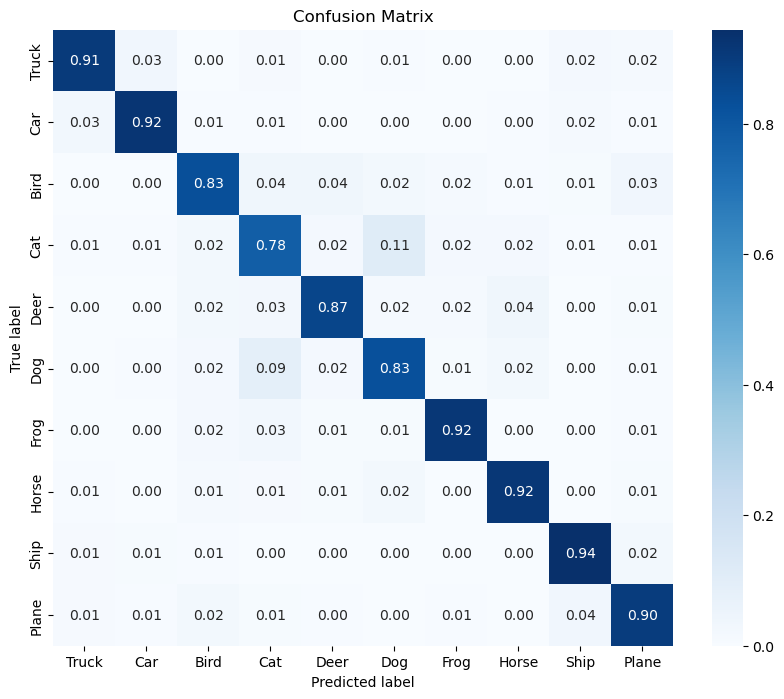

In [16]:
test_loader = DataLoader(validation_ds, batch_size=1000, shuffle=True)

model, _ = multiclass_finetuning(1)
model.load_state_dict(torch.load('./weights/multiclass_finetuning_lr0001_batch256_epochs30.pth'))
model.eval()  
device = next(model.parameters()).device

total_correct = 0
total_images = 0
confusion_matrix = torch.zeros(10, 10)  

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels % 10
        labels = labels.to(device)

        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted % 10
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[label.long(), prediction.long()] += 1

accuracy = total_correct / total_images
test_error = 1 - accuracy

print(f'Test accuracy: {accuracy*100:.2f}%')

confusion_matrix_np = confusion_matrix.numpy()

def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = []
_ = [class_names.append(labels_map[c][5:]) for c in labels_map] 
plot_confusion_matrix(confusion_matrix_np, class_names[:10], (10, 8))